# MLP Implementation on SVHN Dataset

## Initialising CUDA GPU

In [1]:
!nvidia-smi  # displaying information about available GPUs

Fri Nov 17 17:18:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install cudf-cu11 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.6/502.6 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.7/18.7 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.6/89.6 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 582.4/582.4 kB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 62.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 6.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found exi

In [3]:
import cudf

## Importing the libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as sio

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [6]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


## Data Preparation

### Loading the dataset

In [7]:
# load train_32x32.mat using scipy.io.loadmat; this is because .mat is a MATLAB file and to convert into a numpy array, we use scipy.io.loadmat
data = sio.loadmat('train_32x32.mat')
X = data['X']
y = data['y']
X = X.reshape(X.shape[0]*X.shape[1]*X.shape[2], X.shape[3]).T
X.shape, y.shape

((73257, 3072), (73257, 1))

### Split the training dataset into validation (20%) and testing (10%) sets using train_test_split from scikit-learn

In [8]:
TEST_SIZE = 0.1
VAL_SIZE = 0.2
TRAIN_SIZE = 1 - VAL_SIZE - TEST_SIZE
SEED = 2454259

In [9]:
from sklearn.model_selection import train_test_split

def train_test_val_split(X, y, test_size, val_size, seed):
    train_size = 1 - test_size - val_size
    adj_val_size = val_size / (1 - test_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = adj_val_size, random_state = seed)

    return X_train, X_val, X_test, y_train, y_val, y_test


X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y, TEST_SIZE, VAL_SIZE, SEED)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((51279, 3072), (14652, 3072), (7326, 3072), (51279, 1), (14652, 1), (7326, 1))

### Visualize the distribution of class labels in the training, validation, and test sets

train_label
1              9638
2              7441
3              5943
4              5219
5              4823
6              4036
7              3905
8              3569
10             3449
9              3256
dtype: int64


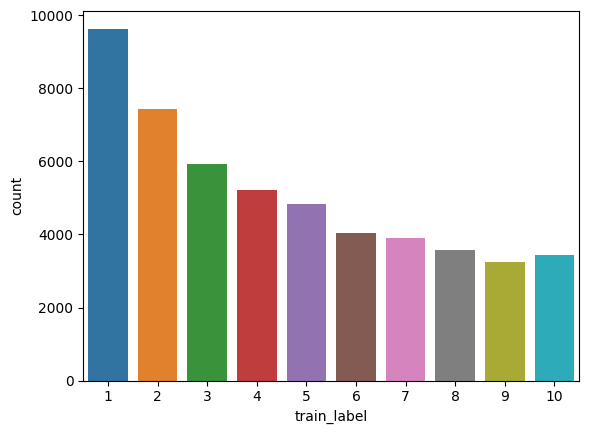

test_label
1             1430
2             1054
3              844
4              755
5              681
6              572
7              543
10             504
9              472
8              471
dtype: int64


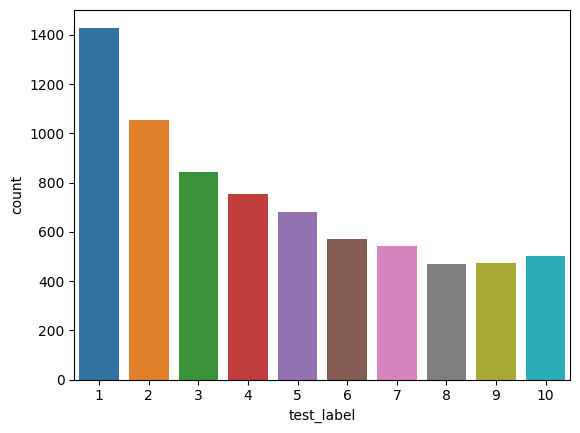

val_label
1            2793
2            2090
3            1710
4            1484
5            1378
7            1147
6            1119
8            1005
10            995
9             931
dtype: int64


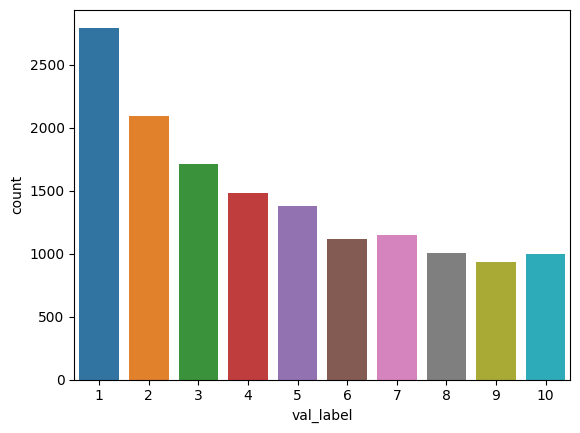

In [ ]:
# Visualize the distribution of class labels in the training, validation, and test sets.
import seaborn as sns

def plot_class_distribution(y_train, y_val, y_test):
    y_train_df = pd.DataFrame(y_train, columns = ['train_label'])
    sns.countplot(x = 'train_label', data = y_train_df)
    print(y_train_df.value_counts())
    plt.show()

    y_test_df = pd.DataFrame(y_test, columns = ['test_label'])
    sns.countplot(x = 'test_label', data = y_test_df)
    print(y_test_df.value_counts())
    plt.show()

    y_val_df = pd.DataFrame(y_val, columns = ['val_label'])
    sns.countplot(x = 'val_label', data = y_val_df)
    print(y_val_df.value_counts())
    plt.show()

    return y_train_df, y_val_df, y_test_df

y_train_df, y_val_df, y_test_df = plot_class_distribution(y_train, y_val, y_test)

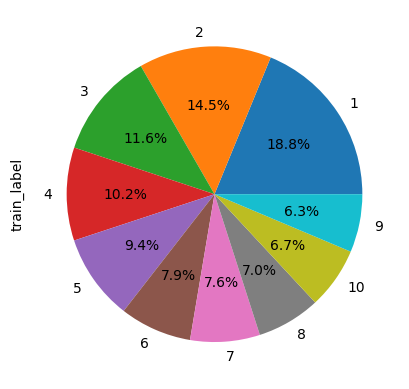

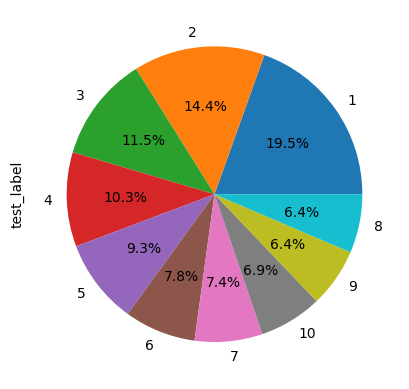

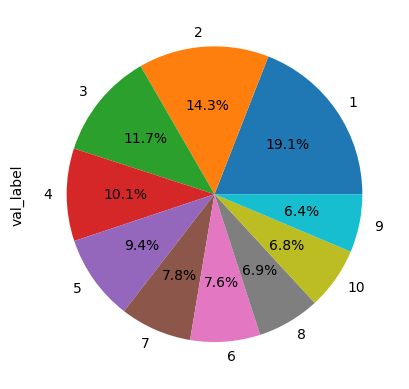

In [ ]:
# plot pie chart for the distribution of class labels in the training, validation, and test sets.

def plot_pie_chart(y_train_df, y_val_df, y_test_df):
    y_train_df['train_label'].value_counts().plot(kind = 'pie', autopct = '%1.1f%%')
    plt.show()

    y_test_df['test_label'].value_counts().plot(kind = 'pie', autopct = '%1.1f%%')
    plt.show()

    y_val_df['val_label'].value_counts().plot(kind = 'pie', autopct = '%1.1f%%')
    plt.show()

    return y_train_df, y_val_df, y_test_df

y_train_df, y_val_df, y_test_df = plot_pie_chart(y_train_df, y_val_df, y_test_df)

### Visualizing 5 unique samples from the training data.

In [10]:
# Reshaping the image data for visualization
X_train_ = X_train.reshape(X_train.shape[0], 32, 32, 3)
X_val_ = X_val.reshape(X_val.shape[0], 32, 32, 3)
X_test_ = X_test.reshape(X_test.shape[0], 32, 32, 3)
y_train = y_train.reshape(y_train.shape[0])
y_val = y_val.reshape(y_val.shape[0])
y_test = y_test.reshape(y_test.shape[0])
X_train_.shape, y_train.shape, X_val_.shape, y_val.shape, X_test_.shape, y_test.shape

((51279, 32, 32, 3),
 (51279,),
 (14652, 32, 32, 3),
 (14652,),
 (7326, 32, 32, 3),
 (7326,))

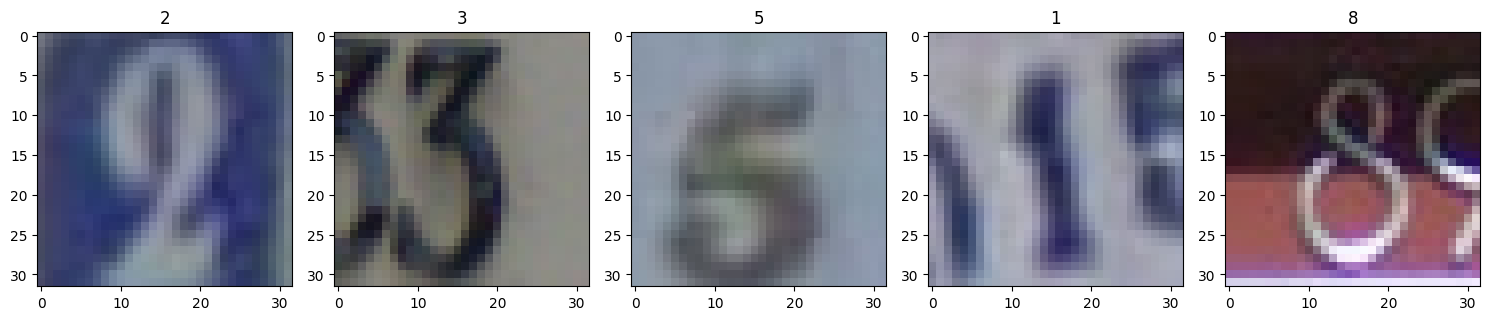

In [11]:
def plot_5_unique_samples(X_train, y_train):
    unique = [0, 2, 6, 8, 25]
    fig, axes = plt.subplots(1, len(unique), figsize = (15, 15))
    for i in range(len(unique)):
        axes[i].imshow(X_train[unique[i]])
        axes[i].set_title(y_train[unique[i]])
    plt.tight_layout()
    plt.show()

plot_5_unique_samples(X_train_, y_train)

##  Model Training and Activation Functions

In [ ]:
# i. Construct a neural network with 2 hidden layers (excluding input and final layers). (1 point)                DONE
# ii. Use Grid-Search to find optimal hyperparameters for batch size and other model parameters. (2 points)
# iii. Train the model using various activation functions: sigmoid, ReLU, tanh, and linear. (2 points)            DONE
# iv. For each activation function, plot the training loss vs. epochs and validation loss vs. epochs. (1 point)   DONE
# v. Analyze whether the model can learn effectively with all activation functions. If not, provide justifications. (2 points)
# vi. Determine the best accuracy achieved on the test set. Is your model able to achieve a decent accuracy? Explain how you reached the set of hyperparameters. (1 point)

### Defining Functions

In [12]:
from sklearn.metrics import log_loss
from tqdm import trange
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [13]:
def train_model(X_train, y_train, X_val, y_val, model, epochs, n_iter_no_change = 10, early_stopping = True, tol = 1e-4):
    train_loss = []
    validation_loss = []
    for epoch in trange(epochs):
        model.partial_fit(X_train, y_train, classes=np.unique(y_train))
        train_loss.append(model.loss_)
        validation_loss.append(log_loss(y_val, model.predict_proba(X_val)))
        # Early stopping
        if early_stopping:
            if epoch > n_iter_no_change:
                if np.mean(validation_loss[-n_iter_no_change:]) - validation_loss[-1] < tol:
                    print("\nStopping early ... ")
                    break

    return model, train_loss, validation_loss

In [14]:
def plot_loss(train_loss, val_loss, label='Relu Activation Function', combined_graph=False):
    if combined_graph:
        plt.plot(train_loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.title(label)
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
    else:
        print(label)
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        axs[0].plot(train_loss)
        axs[0].set_title('Training Loss vs Epochs')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Training Loss')

        axs[1].plot(val_loss)
        axs[1].set_title('Validation Loss vs Epochs')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Validation Loss')
        plt.show()

### Testing Different Hidden Layer Sizes

In [ ]:
model_relu4 = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', batch_size=100, random_state=SEED)
model_relu4, train_loss_relu4, validation_loss_relu4 = train_model(X_train, y_train, X_val, y_val, model_relu4, 200)
print("Accuracy with hidden layer size (64, 32) on training set with activation function relu:", model_relu4.score(X_test, y_test))

  6%|▌         | 11/200 [01:22<23:36,  7.49s/it]


Stopping early ... 
Accuracy on training set with activation function relu: 0.19519519519519518


In [ ]:
model_relu3 = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', batch_size=100, random_state=SEED)
model_relu3, train_loss_relu3, validation_loss_relu3 = train_model(X_train, y_train, X_val, y_val, model_relu3, 200)
print("Accuracy with hidden layer size (128, 64) on training set with activation function relu:", model_relu3.score(X_test, y_test))

  8%|▊         | 15/200 [02:36<32:07, 10.42s/it]


Stopping early ... 


Accuracy with hidden layer size (64, 32) on training set with activation function relu: 0.36663936663936664


In [ ]:
model_relu2 = MLPClassifier(hidden_layer_sizes=(256, 128), activation='relu', batch_size=100, random_state=SEED)
model_relu2, train_loss_relu2, validation_loss_relu2 = train_model(X_train, y_train, X_val, y_val, model_relu2, 200)
print("Accuracy with hidden layer size (256, 128) on training set with activation function relu:", model_relu2.score(X_test, y_test))

 20%|██        | 40/200 [17:57<1:11:49, 26.94s/it]


Stopping early ... 


Accuracy with hidden layer size (256, 128) on training set with activation function relu: 0.6924651924651924


In [ ]:
model_relu1 = MLPClassifier(hidden_layer_sizes=(512, 256), activation='relu', batch_size=100, random_state=SEED)
model_relu1, train_loss_relu1, validation_loss_relu1 = train_model(X_train, y_train, X_val, y_val, model_relu1, 200)
print("Accuracy with hidden layer size (512, 256) on training set with activation function relu:", model_relu1.score(X_test, y_test))

 16%|█▌        | 32/200 [22:03<1:55:46, 41.35s/it]


Stopping early ... 


Accuracy with hidden layer size (512, 256) on training set with activation function relu: 0.6651651651651652


In [ ]:
# plot_loss(train_loss_relu1, validation_loss_relu1, label='Hidden Layer Size: (512, 256)', combined_graph=True)
# plot_loss(train_loss_relu2, validation_loss_relu2, label='Hidden Layer Size: (256, 128)', combined_graph=True)
# plot_loss(train_loss_relu3, validation_loss_relu3, label='Hidden Layer Size: (128, 64)', combined_graph=True)
# plot_loss(train_loss_relu4, validation_loss_relu4, label='Hidden Layer Size: (64, 32)', combined_graph=True)

NOTE: We see that increasing the number of neurons after (256, 128) will lead to overfitting and thus reducing the test accuracy. Thus testing further on taking slight variations of (256, 128) neurons -

In [ ]:
model_relu2_1 = MLPClassifier(hidden_layer_sizes=(256, 64), activation='relu', batch_size=100, random_state=SEED)
model_relu2_1, train_loss_relu2_1, validation_loss_relu2_1 = train_model(X_train, y_train, X_val, y_val, model_relu2_1, 200)
print("Accuracy with hidden layer size (256, 64) on training set with activation function relu:", model_relu2_1.score(X_test, y_test))

  6%|▋         | 13/200 [04:35<1:06:10, 21.23s/it]


Stopping early ... 


Accuracy with hidden layer size (256, 64) on training set with activation function relu: 0.19519519519519518


In [ ]:
model_relu2_2 = MLPClassifier(hidden_layer_sizes=(128, 128), activation='relu', batch_size=100, random_state=SEED)
model_relu2_2, train_loss_relu2_2, validation_loss_relu2_2 = train_model(X_train, y_train, X_val, y_val, model_relu2_2, 200)
print("Accuracy with hidden layer size (128, 128) on training set with activation function relu:", model_relu2_2.score(X_test, y_test))

  6%|▌         | 12/200 [02:25<38:00, 12.13s/it]


Stopping early ... 


Accuracy with hidden layer size (256, 64) on training set with activation function relu: 0.42001092001092


In [ ]:
model_relu2_3 = MLPClassifier(hidden_layer_sizes=(256, 256), activation='relu', batch_size=100, random_state=SEED)
model_relu2_3, train_loss_relu2_3, validation_loss_relu2_3 = train_model(X_train, y_train, X_val, y_val, model_relu2_3, 200)
print("Accuracy with hidden layer size (256, 256) on training set with activation function relu:", model_relu2_3.score(X_test, y_test))

  6%|▌         | 11/200 [04:42<1:21:00, 25.72s/it]


Stopping early ... 


Accuracy with hidden layer size (256, 256) on training set with activation function relu: 0.48348348348348347


NOTE: This implies that if we increase or decrease the no of neurons in each hidden layer then we see a dip in our accuracy. Hence the optimal hidden layer size would be (256, 128).

Also note that for running the MLPClassifier with (256, 128) neurons a huge amount of time is required. But, for running with (256, 256) neurons only 4 minutes approx are taken with an accuracy around 50%.

In [16]:
best_hidden_layer_size = (256, 128)
best_adjusted_size = (256, 256)

### Testing Different Activation Functions

#### Relu Activation Function

In [18]:
model_relu = MLPClassifier(hidden_layer_sizes = (256, 128), activation='relu', batch_size=100, random_state=SEED)
model_relu, train_loss_relu, validation_loss_relu = train_model(X_train, y_train, X_val, y_val, model_relu, 200)
print("Accuracy on training set with activation function relu:", model_relu.score(X_test, y_test))
# model_relu = model_relu2
# train_loss_relu = train_loss_relu2
# validation_loss_relu = validation_loss_relu2
# print("Accuracy on training set with activation function relu:", model_relu.score(X_test, y_test))

  9%|▉         | 18/200 [05:44<57:59, 19.12s/it]


Stopping early ... 


Accuracy on training set with activation function relu: 0.5771225771225771


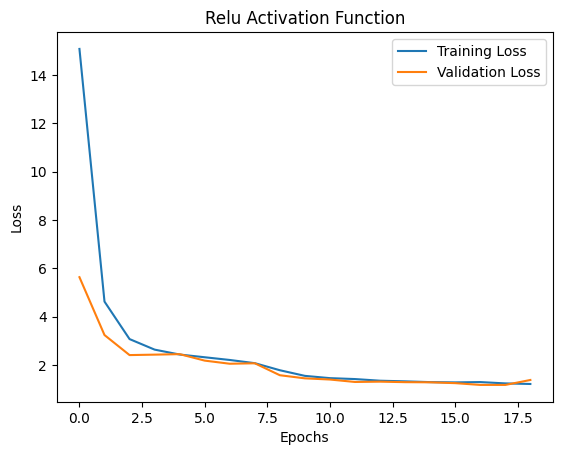

In [19]:
plot_loss(train_loss_relu, validation_loss_relu, label='Relu Activation Function', combined_graph=True)

#### Tanh Activation Function

In [ ]:
model_tanh = MLPClassifier(hidden_layer_sizes = best_hidden_layer_size, activation='tanh', batch_size=100, random_state=SEED)
model_tanh, train_loss_tanh, validation_loss_tanh = train_model(X_train, y_train, X_val, y_val, model_tanh, 200)
print("Accuracy on training set with activation function tanh:", model_tanh.score(X_test, y_test))

  6%|▌         | 11/200 [04:16<1:13:28, 23.32s/it]


Stopping early ... 


Accuracy on training set with activation function tanh: 0.14387114387114386


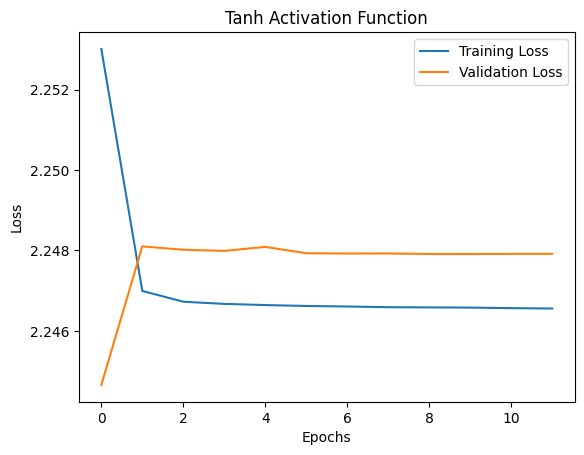

In [ ]:
plot_loss(train_loss_tanh, validation_loss_tanh, label='Tanh Activation Function', combined_graph=True)

#### Linear Activation Function

In [ ]:
model_identity = MLPClassifier(hidden_layer_sizes = best_hidden_layer_size, activation='identity', batch_size=100, random_state=SEED)
model_identity, train_loss_identity, validation_loss_identity = train_model(X_train, y_train, X_val, y_val, model_identity, 200)
print("Accuracy on training set with activation function linear:", model_identity.score(X_test, y_test))

  8%|▊         | 15/200 [05:58<1:13:45, 23.92s/it]


Stopping early ... 


Accuracy on training set with activation function linear: 0.12435162435162435


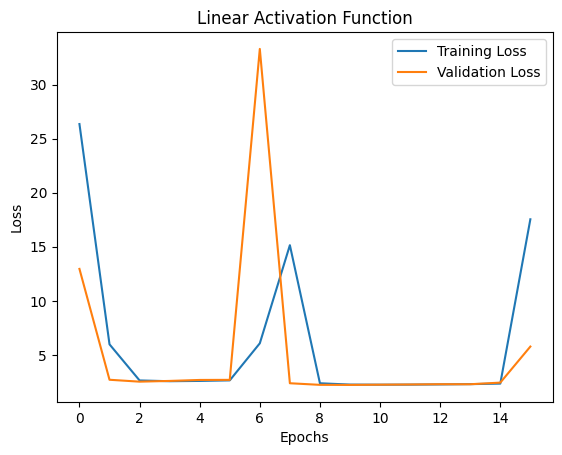

In [ ]:
plot_loss(train_loss_identity, validation_loss_identity, label='Linear Activation Function', combined_graph=True)

#### Sigmoid Activation Function

In [ ]:
model_logistic = MLPClassifier(hidden_layer_sizes = best_hidden_layer_size, activation='logistic', batch_size=100, random_state=SEED)
model_logistic, train_loss_logistic, validation_loss_logistic = train_model(X_train, y_train, X_val, y_val, model_logistic, 200)
print("Accuracy on training set with activation function sigmoid:", model_logistic.score(X_test, y_test))

  6%|▋         | 13/200 [06:01<1:26:44, 27.83s/it]


Stopping early ... 


Accuracy on training set with activation function sigmoid: 0.19519519519519518


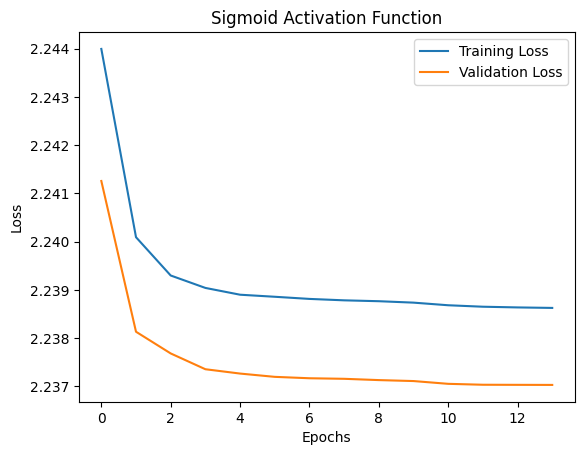

In [ ]:
plot_loss(train_loss_logistic, validation_loss_logistic, label='Sigmoid Activation Function', combined_graph=True)

NOTE: We see that the best activation function is ReLU

In [ ]:
best_activation_function = 'relu'

### Testing on different initial learning rates

In [ ]:
model_0001 = MLPClassifier(hidden_layer_sizes = best_hidden_layer_size, activation = best_activation_function, learning_rate_init = 0.0001, batch_size=100, random_state=SEED)
model_0001, train_loss_0001, validation_loss_0001 = train_model(X_train, y_train, X_val, y_val, model_0001, 200)
print("Accuracy on training set with initial learning rate 0.0001:", model_0001.score(X_test, y_test))

 16%|█▋        | 33/200 [14:19<1:12:29, 26.05s/it]


Stopping early ... 


Accuracy on training set with initial learning rate 0.0001: 0.6784056784056784


In [ ]:
model_001 = MLPClassifier(hidden_layer_sizes = best_hidden_layer_size, activation = best_activation_function, learning_rate_init = 0.001, batch_size=100, random_state=SEED)
model_001, train_loss_001, validation_loss_001 = train_model(X_train, y_train, X_val, y_val, model_001, 200)
print("Accuracy on training set with initial learning rate 0.001:", model_001.score(X_test, y_test))

 20%|██        | 40/200 [23:20<1:33:20, 35.01s/it]


Stopping early ... 


Accuracy on training set with initial learning rate 0.001: 0.6924651924651924


In [ ]:
model_01 = MLPClassifier(hidden_layer_sizes = best_hidden_layer_size, activation = best_activation_function, learning_rate_init = 0.01, batch_size=100, random_state=SEED)
model_01, train_loss_01, validation_loss_01 = train_model(X_train, y_train, X_val, y_val, model_01, 200)
print("Accuracy on training set with initial learning rate 0.01:", model_01.score(X_test, y_test))

  6%|▌         | 11/200 [05:03<1:27:03, 27.64s/it]


Stopping early ... 


Accuracy on training set with initial learning rate 0.01: 0.19519519519519518


In [ ]:
model_1 = MLPClassifier(hidden_layer_sizes = best_hidden_layer_size, activation = best_activation_function, learning_rate_init = 0.1, batch_size=100, random_state=SEED)
model_1, train_loss_1, validation_loss_1 = train_model(X_train, y_train, X_val, y_val, model_1, 200)
print("Accuracy on training set with initial learning rate 0.1:", model_1.score(X_test, y_test))

  6%|▌         | 11/200 [04:50<1:23:18, 26.45s/it]


Stopping early ... 


Accuracy on training set with initial learning rate 0.1: 0.14387114387114386


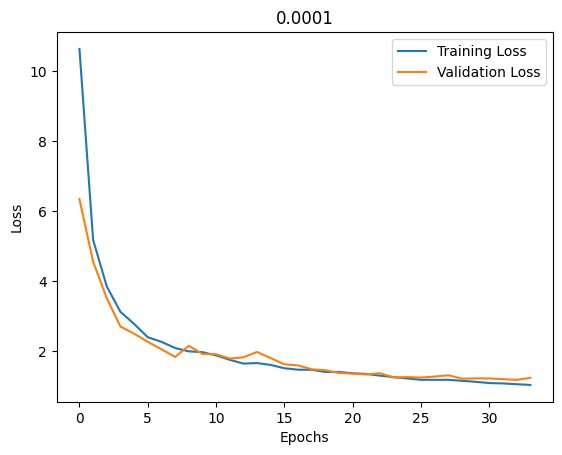

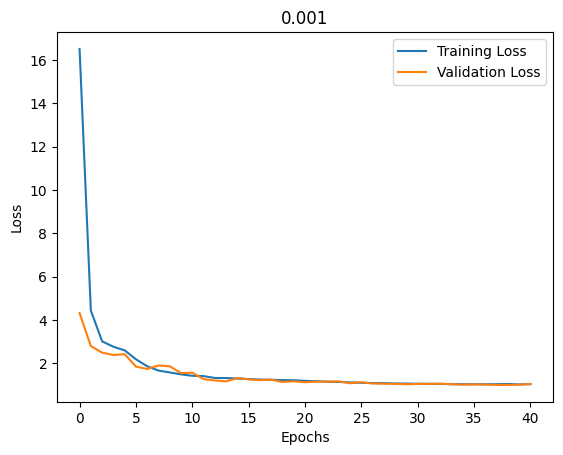

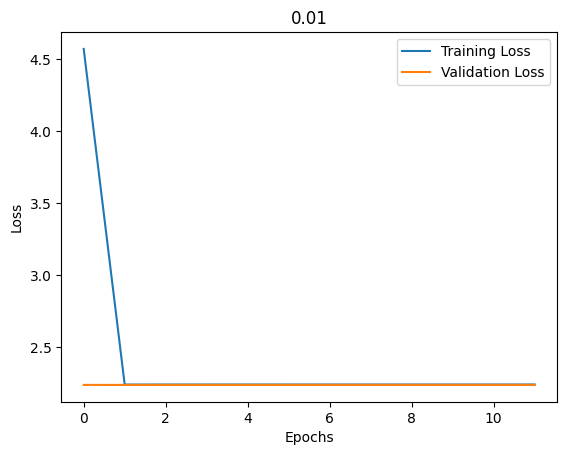

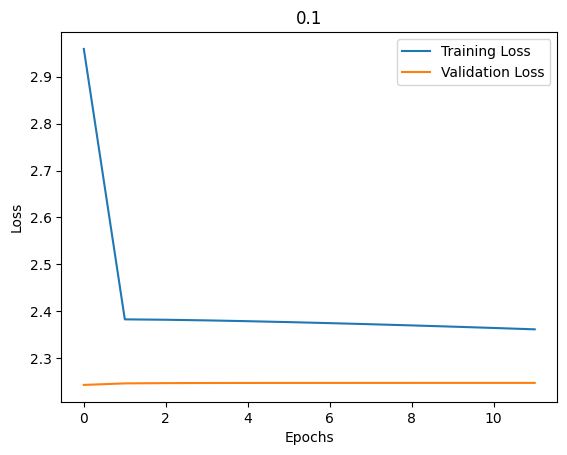

In [ ]:
plot_loss(train_loss_0001, validation_loss_0001, label='0.0001', combined_graph=True)
plot_loss(train_loss_001, validation_loss_001, label='0.001', combined_graph=True)
plot_loss(train_loss_01, validation_loss_01, label='0.01', combined_graph=True)
plot_loss(train_loss_1, validation_loss_1, label='0.1', combined_graph=True)

NOTE: We observe that the best initial learning rate is 0.001

In [ ]:
best_learning_rate_init = 0.001

### Hyperparameter tuning using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def grid_search(X_train, y_train, X_val, y_val):
    model = MLPClassifier(random_state = SEED, early_stopping=True, validation_fraction = 0.15)
    param = {
        'hidden_layer_sizes': [(256, 128)],
        'activation': ['relu'],
        'batch_size': [128, 64, 32],
        'solver': ['sgd', 'adam'],
        'learning_rate_init': [0.001],
        'alpha': [0.0001, 0.001]
    }
    # scorer = make_scorer(accuracy_score)
    # 'max_iter': []
    clf = GridSearchCV(model, param_grid=param, cv=1, verbose = 2, n_jobs=-1)
    clf.fit(X_train, y_train)
    return clf

clf = grid_search(X_train, y_train, X_val, y_val)
best_model = clf.best_estimator_
print('Best parameters: ', clf.best_params_)
print('Best accuracy: ', clf.best_score_)
print('Accuracy on test model:', best_model.score(X_test, y_test))

Fitting 1 folds for each of 12 candidates, totalling 12 fits


KeyboardInterrupt: ignored

### Visualization of Incorrect Predictions

In [ ]:
# i. For each class in the test set, visualize 3 misclassified images along with their predicted class labels. (1.5 points)
# ii. Analyze possible reasons for model misclassification. Consider whether the misclassified images resemble
#     the predicted class more than the actual class, or if other factors are contributing. (1.5 points)

  9%|▉         | 18/200 [05:48<58:40, 19.34s/it]


Stopping early ... 


Accuracy on training set: 0.5771225771225771


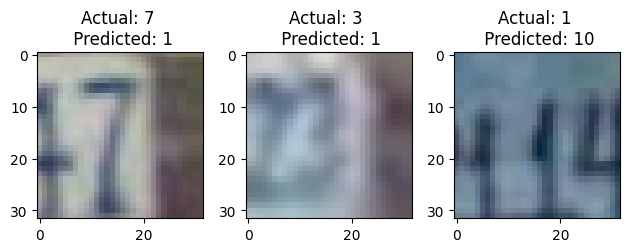

In [20]:
def plot_misclassified_images(y_pred, y_test, X_test):
    misclassified = (np.where(y_pred != y_test)[0])[:3]
    fig, axes = plt.subplots(1, len(misclassified))
    X_test__ = X_test.reshape(X_test.shape[0], 32, 32, 3)
    for i in range(len(misclassified)):
        axes[i].imshow(X_test__[misclassified[i]])
        axes[i].set_title('Actual: {} \n Predicted: {}'.format(y_test[misclassified[i]], y_pred[misclassified[i]]))
    plt.tight_layout()
    plt.show()

model = MLPClassifier(hidden_layer_sizes = (256, 128), activation = 'relu', learning_rate_init = 0.001, batch_size=100, random_state=SEED)
model, train_loss, validation_loss = train_model(X_train, y_train, X_val, y_val, model, 200)
print("Accuracy on training set:", model.score(X_test, y_test))
y_pred = model.predict(X_test)
plot_misclassified_images(y_pred, y_test, X_test)